# Method 1 - EN 12603

Statistical evaluation of failure stresses. 

The process is as follows:
- Calculate the stress at failure for each specimen and sort them in increasing order of magnitude: $ \sigma_i $, where $ i $ is the rank number.
- Calculate the probability of failure $ P_{f,i} $ for each measured value. Use the following estimator:
$
  P_{f,i} = \frac{i}{n+1}
$
  where $ n $ is the number of tested samples.
- Put the Weibull distribution into linearized form. Enter the measured data into the Weibull mesh.
- Fit the data by linear regression. Find the slope, the intercept, and the coefficient of determination $ R^2 $.
- Determine the Weibull parameters $ \lambda $ (shape parameter) and $ \beta $ (scale parameter).
- Calculate the confidence interval $ C $ and plot it on the Weibull mesh.
- Determine the 5% fractile value of the bending tensile strength $ f_y $ using the regression line and using the confidence interval. In the case of the confidence interval, use the target goal seek.
- Plot the cumulative distribution function $ F(x) $ and the density function $ f(x) $.

In [37]:
import numpy as np
import pandas as pd
from scipy.stats import weibull_min, linregress, t
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

### Input the failure stress rates from experimental data.

In [38]:
stress_rates = np.array([57.0571,53.1429,57.2857,58.3429,58.6286,62.8000,67.7143,68.8857,76.3429,76.4571,77.4571,79.0000,82.1714,87.5429])

### Start of Statistical evaluation

x_5 is 3.8233143386823807
The value of x that makes f(x) = -2.9701952490421655 is: 3.8798551676529685
The value of x that makes f(x) = -2.9701952490421655 is: 3.7481658869112016
95% Confidence Interval of 5% Fractile: (42.44, 48.42) MPa
5% Fractile Stress: 45.76 MPa


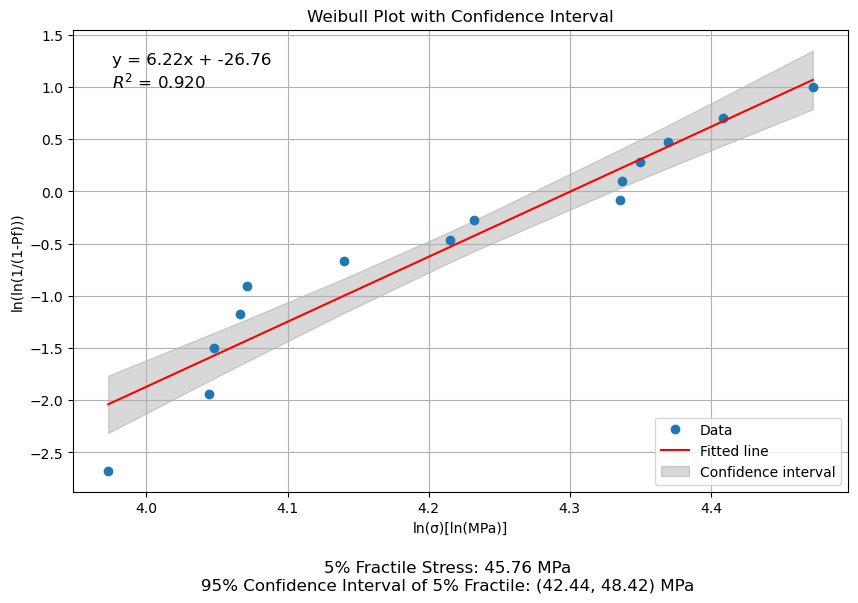

Weibull shape parameter (λ): 6.221454068463654
Weibull scale parameter (β): 73.75332541758777
Slope: 6.221454068463654
Intercept: -26.75676979645309
R-squared: 0.9200991171875372
T-value for 95% confidence: 1.782287555649159


In [39]:
# Sort the stress in increasing order
sorted_stress = np.sort(stress_rates)

# Calculate probability of failure (P_f,i)
n = len(sorted_stress)

P_f = np.array([(i + 1) / (n + 1) for i in range(n)])

# Linearize the Weibull distribution
ln_stress = np.log(sorted_stress)

ln_ln_Pf = np.log(np.log(1 / (1 - P_f)))

# Perform linear regression
slope, intercept, r_value, p_value, std_error = linregress(ln_stress, ln_ln_Pf)

def steyx(x, y):
    n = len(x)
    if len(y) != n:
        raise ValueError("x and y must have the same length")
    
    x_mean = np.mean(x)
    y_mean = np.mean(y)

    # Calculate the slope and intercept
    slope = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean) ** 2)
    intercept = y_mean - slope * x_mean

    # Calculate predicted y-values
    y_pred = slope * x + intercept

    # Calculate standard error
    se = np.sqrt(np.sum((y - y_pred) ** 2) / (n - 2))
    return se

std_err = steyx(ln_stress, ln_ln_Pf)

# Calculate the standard error
se = std_err

# Calculate the t-value for 95% confidence
alpha = 0.10
t_value = t.ppf(1 - alpha/2, df=n-2)

# Calculate the confidence interval
mean_ln_stress = np.mean(ln_stress)

C = t_value * se * np.sqrt(1/n + (ln_stress - mean_ln_stress)**2 / np.sum((ln_stress - mean_ln_stress)**2))

# Determine the 5% fractile
Pf_5 = 0.05
ln_ln_Pf_5 = np.log(np.log(1 / (1 - Pf_5)))
x_5 = (ln_ln_Pf_5 - intercept) / slope  # ln(Stress) for 5% fractile
print(f"x_5 is {x_5}")
stress_5_percentile = np.exp(x_5)

# Set the target value
# Determine the 5% fractile
target_value = np.log(np.log(1 / (1 - Pf_5)))

# Define confidence function
def CI(x):
    return t_value * se * np.sqrt(1/n + (x - mean_ln_stress)**2 / np.sum((ln_stress - mean_ln_stress)**2))

# Define the function of the upper confidence interval
def f_upper(x):
    return slope*x + intercept - CI(x) 

# Define the function of the lower confidence interval
def f_lower(x):
    return slope*x + intercept + CI(x) 

# Define a function that subtracts the target value
def goal_seek_function_CI_upper(x):
    return f_upper(x) - target_value

# Define a function that subtracts the target value
def goal_seek_function_CI_lower(x):
    return f_lower(x) - target_value

# Initial guess
initial_guess = 3.0

# Use fsolve to perform the goal seek for the upper value of the confidence interval
solution_CI_upper = fsolve(goal_seek_function_CI_upper, initial_guess)
# Use fsolve to perform the goal seek for the lower value of the confidence interval
solution_CI_lower = fsolve(goal_seek_function_CI_lower, initial_guess)

# Output the solution
print(f"The value of x that makes f(x) = {target_value} is: {solution_CI_upper[0]}")
print(f"The value of x that makes f(x) = {target_value} is: {solution_CI_lower[0]}")
stress_5_percentile_CI_upper = np.exp(solution_CI_upper[0])
stress_5_percentile_CI_lower = np.exp(solution_CI_lower[0])

print(f"95% Confidence Interval of 5% Fractile: ({stress_5_percentile_CI_lower:.2f}, {stress_5_percentile_CI_upper:.2f}) MPa")
print(f"5% Fractile Stress: {stress_5_percentile:.2f} MPa")

# Plot with confidence interval
plt.figure(figsize=(10, 6))
plt.plot(ln_stress, ln_ln_Pf, 'o', label='Data')
plt.plot(ln_stress, slope * ln_stress + intercept, 'r', label='Fitted line')
plt.fill_between(ln_stress, slope * ln_stress + intercept - C, slope * ln_stress + intercept + C, color='grey', alpha=0.3, label='Confidence interval')
plt.xlabel(f'ln(\u03C3)[ln(MPa)]')
plt.ylabel('ln(ln(1/(1-Pf)))')
plt.title('Weibull Plot with Confidence Interval')
plt.legend()
plt.grid(True)

# Add regression equation and R-squared to the plot
regression_text = f"y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_value**2:.3f}"
plt.annotate(regression_text, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
             horizontalalignment='left', verticalalignment='top')

# Add text below the x-axis label
plt.figtext(0.5, -0.05, f"5% Fractile Stress: {stress_5_percentile:.2f} MPa\n95% Confidence Interval of 5% Fractile: ({stress_5_percentile_CI_lower:.2f}, {stress_5_percentile_CI_upper:.2f}) MPa",
            wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

# Weibull Parameters estimation
shape = slope
scale = np.exp(-intercept/slope)
print(f"Weibull shape parameter (λ): {shape}")
print(f"Weibull scale parameter (β): {scale}")

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"T-value for 95% confidence: {t_value}")

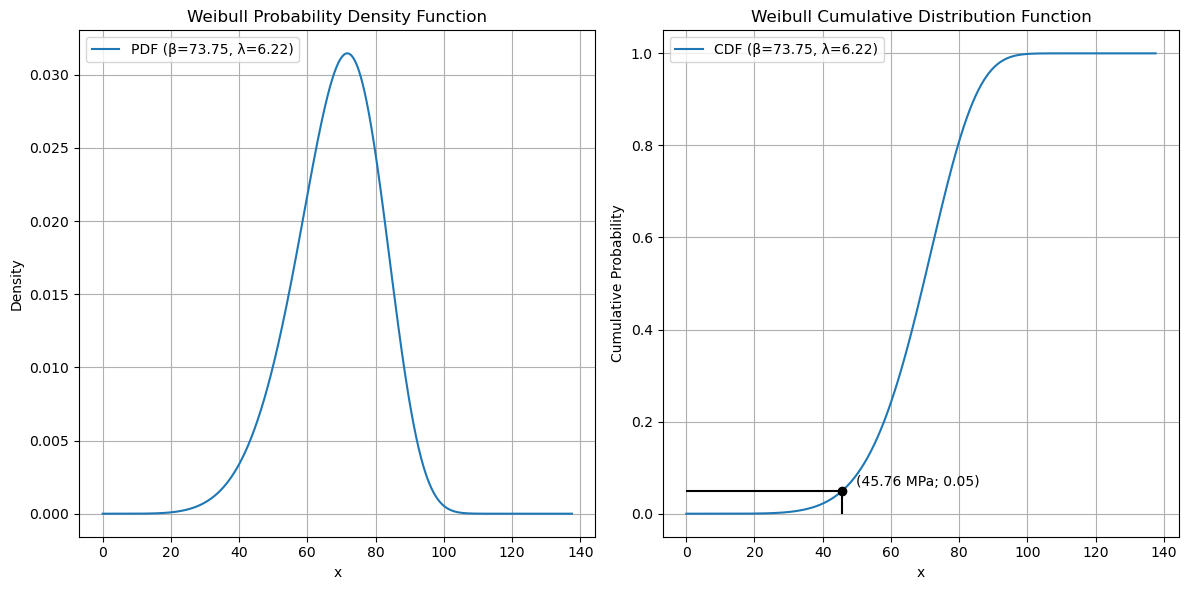

In [40]:
# Parameters for Weibull distribution
beta = scale     # scale parameter
lambda_ = shape  # shape parameter

# Creating a range of x values
x = np.linspace(0,max(stress_rates)+50,1000)

# Weibull PDF
def weibull_pdf(x, beta, lambda_):
    return (lambda_ / beta) * (x / beta)**(lambda_ - 1) * np.exp(-(x / beta)**lambda_)

# Weibull CDF
def weibull_cdf(x, beta, lambda_):
    return 1 - np.exp(-(x / beta)**lambda_)

# Calculate PDF and CDF
pdf_values = weibull_pdf(x, beta, lambda_)
cdf_values = weibull_cdf(x, beta, lambda_)

# Calculate the 5% fractile
five_percentile = beta * (-np.log(0.95))**(1/lambda_)

# Plotting
plt.figure(figsize=(12, 6))

# Plot PDF
plt.subplot(1, 2, 1)
plt.plot(x, pdf_values, label=f"PDF (\u03B2={beta:.2f}, \u03BB={lambda_:.2f})")
plt.title('Weibull Probability Density Function')
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(True)
plt.legend(loc='upper left')

# Plot CDF
plt.subplot(1, 2, 2)
plt.plot(x, cdf_values, label=f"CDF (\u03B2={beta:.2f}, \u03BB={lambda_:.2f})")
plt.hlines(0.05, 0, five_percentile, color='black', linestyle='-')
plt.vlines(five_percentile, 0, 0.05, color='black', linestyle='-')

# Add a circular marker at the 5% fractile
plt.scatter([five_percentile], [0.05], color='black', zorder=5)

# Annotate the 5% fractile
plt.text(five_percentile + 4, 0.06, f'({five_percentile:.2f} MPa; 0.05)', fontsize=10)
plt.title('Weibull Cumulative Distribution Function')
plt.xlabel('x')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


#print(f"The 5% fractile value is: {five_percentile:.4f} MPa")